# 時系列のinnovationの推定をwganでやってみたい

$$X_t=F_{\phi}(X_{t-1}, X_{t-2},\cdots, X_{t-p}, \varepsilon_t, \varepsilon_{t-1},\cdots,\varepsilon_{t-q})$$ 

と言うダイナミクスにより生成された時系列。この観測データからinnovation $\varepsilon_t$を推定したい

<img src="../images/時系列モデル.jpeg" alt="時系列モデル" title="サンプル" width=50%>

innovationとしては、i.i.dな正規分布$\mathcal{N}(0,\sigma^2)$になって欲しい

<img src="../images/wganの概観.jpeg" alt="wganbの概観" title="サンプル" width=50%>

$\sigma$も学習させた方がいいのかな？

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import numpy as np
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
path

'/home/lab/ryuichi/Documents/research/timeseries-WGAN'

In [3]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# "output-images"フォルダを作成（既にあるならそれで良し）
os.makedirs("output-images", exist_ok=True)
os.makedirs("parameters", exist_ok=True)

In [6]:
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20000, help="Discriminatorを学習させる回数")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
parser.add_argument("--random_seed", type=int, default=0, help="訓練データの時系列のどの時刻を学習に用いるかをランダムに決定する時のシード")
parser.add_argument("--n_cpu", type=int, default=os.cpu_count(), help="number of cpu threads to use during batch generation")
parser.add_argument("--p", type=int, default=7, help="ARの次数(generatorへの入力の次元)")
parser.add_argument("--q", type=int, default=3, help="MAの次数(generatorからの出力の次元)")
parser.add_argument("--generator_seed", type=int, default=0, help="generatorのパラメータの初期値のシード")
parser.add_argument("--discriminator_seed", type=int, default=0, help="discriminatorのパラメータの初期値のシード")
parser.add_argument("--generator_kernel_size", type=int, default=5, help="generatorの中の畳み込みフィルタの大きさ（必ず奇数にすること）")
parser.add_argument("--n_filter", type=int, default=8, help="generatorの最初に生データにかけるフィルタの数")
parser.add_argument("--discriminator_hidden_unit", type=int, default=64, help="discriminatorの隠れ層のニューロンの数")
parser.add_argument("--n_critic", type=int, default=5, help="一度generatorをbackpropするごとに何回discriminatorをbackpropするか")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="batchを何回学習させる度にgeneratorの出力を保存するか")
parser.add_argument("--withGP", type=bool, default=False, help="clipingの代わりにGradient Penaltyを加えるかどうか。True/False")
# opt = parser.parse_args()
opt = parser.parse_args(args=[])

opt.n_epochs=10
opt.random_seed=2
opt.withGP=True

print(opt)

Namespace(batch_size=64, clip_value=0.01, discriminator_hidden_unit=64, discriminator_seed=0, generator_kernel_size=5, generator_seed=0, lr=5e-05, n_cpu=64, n_critic=5, n_epochs=10, n_filter=8, p=7, q=3, random_seed=2, sample_interval=400, withGP=True)


In [7]:
# gpuが使えるかどうか
cuda = True if torch.cuda.is_available() else False
print("GPUは使えますか？ (True/False)  ----> ",cuda)

GPUは使えますか？ (True/False)  ---->  True


In [8]:
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください : ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if torch.cuda.is_available() else 'cpu')

使用するGPUの番号を入れてください : 0


In [9]:
torch.manual_seed(opt.generator_seed)
generator = models.Generator(n_filter=opt.n_filter, generator_kernel_size=opt.generator_kernel_size, p=opt.p, q=opt.q)

In [10]:
a= torch.rand([64,1,opt.p+1])
print("input size   :",a.shape)
b = generator(a)
print("output size:",b.shape)

input size   : torch.Size([64, 1, 8])
output size: torch.Size([64, 4])


In [11]:
# インスタンスの作成
torch.manual_seed(opt.discriminator_seed)
discriminator = models.Discriminator(q=opt.q, discriminator_hidden_unit=opt.discriminator_hidden_unit)

In [12]:
print(discriminator)

Discriminator(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [13]:
# 入出力の大きさの確認
a = torch.rand([opt.batch_size, opt.q+1])
print("input size   :",a.shape)
b = discriminator(a, is_from_generator=True)
print("output size:",b.shape)

input size   : torch.Size([64, 4])
output size: torch.Size([64, 1])


In [14]:
# パラメータの確認
print(discriminator.state_dict().keys())
discriminator.state_dict()['sigma']

odict_keys(['sigma', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


tensor([1.])

In [15]:
for _ in discriminator.parameters():
    print(_.shape)
#     print(_)    

torch.Size([1])
torch.Size([64, 4])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])


In [16]:
class Net(nn.Module):
    def __init__(self, n_unit1, n_unit2):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(opt.p+opt.q+1, n_unit1)
        self.fc2 = nn.Linear(n_unit1, n_unit2)
        self.fc3 = nn.Linear(n_unit2,1)
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

In [17]:
net = Net(n_unit1=16, n_unit2=32)

In [18]:
# 入出力の大きさの確認
a = torch.rand([opt.batch_size, opt.p+opt.q+1])
print("input size   :",a.shape)
b = net(a)
print("output size:",b.shape)

input size   : torch.Size([64, 11])
output size: torch.Size([64, 1])


## データの生成

線形モデルによる人工データ

In [19]:
# Data = tsModel.SARIMA(a=[0.3,-0.4,0.3,-0.4,0.3,-0.4,0.3], b=[0.1,-0.1,0.3], N=1400)
# Data = torch.tensor(Data)
# plt.plot(Data)

ニューラルネットを用いた非線形モデルによる人工データ

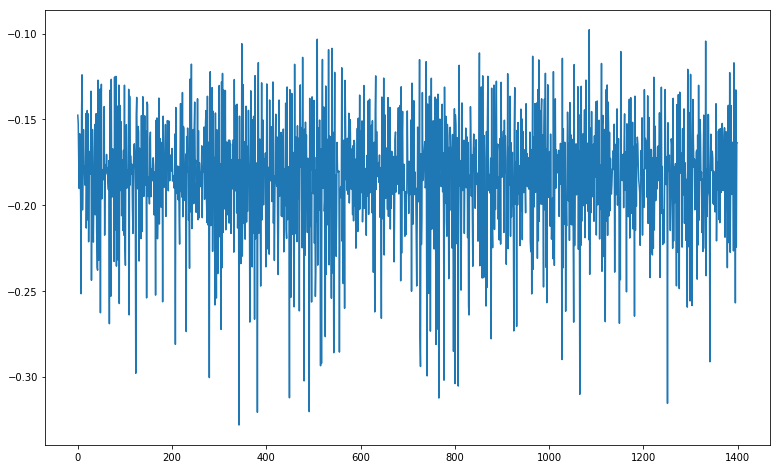

In [20]:
Data = tsModel.NeuralNet(random_seed=10, p=opt.p, q=opt.q, n_unit=[16,16], sigma=2, N=1400, return_net=False)
plt.figure(figsize=(13,8))
plt.plot(Data)

In [21]:
Data=Data.view(1,-1)
Data.shape

torch.Size([1, 1400])

In [22]:
trainData = Data[:,:1000]
valData = Data[:,1000:1200]
testData = Data[:,1200:]

In [23]:
trainData.shape

torch.Size([1, 1000])

In [24]:
trainMatrix = []
for i in range(trainData.shape[1]-(opt.p+1)):
    ans = trainData[:,i:i+opt.p+1].view(1,Data.shape[0],-1)
    trainMatrix.append(ans)
trainMatrix = torch.cat(trainMatrix)
trainMatrix.shape

torch.Size([992, 1, 8])

In [25]:
valMatrix = []
for i in range(valData.shape[1]-(opt.p+1)):
    ans = valData[:,i:i+opt.p+1].view(1,Data.shape[0],-1)
    valMatrix.append(ans)
valMatrix = torch.cat(valMatrix)
valMatrix.shape

torch.Size([192, 1, 8])

## 学習

In [26]:
# Optimizers(パラメータに対して定義される)
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)
optimizer_F = torch.optim.Adam(net.parameters())

In [27]:
# パラメータと学習データをGPUに乗っける
generator.to(device)
discriminator.to(device)
net.to(device)

trainMatrix=trainMatrix.to(device)
valMatrix=valMatrix.to(device)

In [28]:
one = torch.FloatTensor([1]).to(device)
mone = one*-1

### Gradient Penalty用の関数

In [29]:
def gradient_penalty(generated_data, real_data, gp_weight=10):

    batch_size = real_data.size()[0]

    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    if cuda:
        alpha=alpha.to(device)

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if cuda:
        interpolated=interpolated.to(device)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).to(device) if cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)# これいらないかも...
    
    # gradients_norm = (gradients.norm(2, dim=1) - 1) ** 2
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)# 0除算を防ぐ？

    return gp_weight * ((gradients_norm - 1) ** 2).mean()

### まずはgeneratorとdiscriminatorを学習させて、その後に$F_{\phi}$を学習させてみる

In [30]:
saveModel = input('作成したモデルを保存しますか？ （Yes：1, No：0）  ----> ')
saveModel = bool(int(saveModel))

作成したモデルを保存しますか？ （Yes：1, No：0）  ----> 0


In [31]:
import japanize_matplotlib
from scipy.stats import gaussian_kde

[Epoch 0/10] [Batch 0/15] [D loss: 9.585746] [G loss: -0.055318]


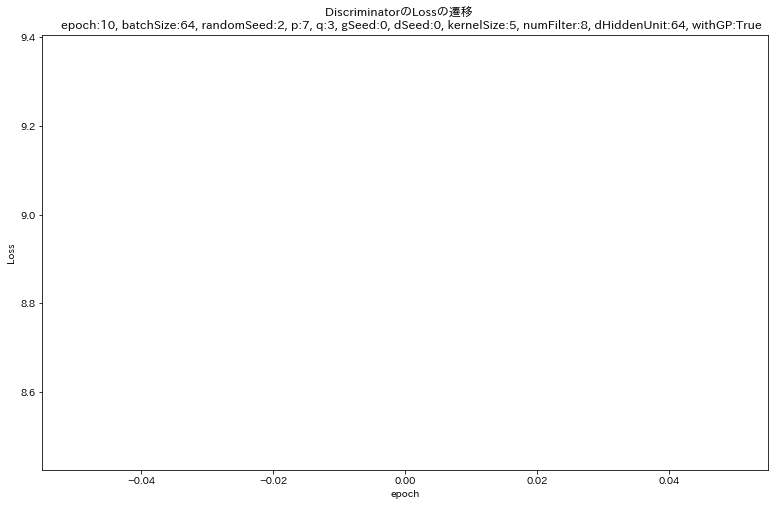

[Epoch 6/10] [Batch 1/15] [D loss: 6.019310] [G loss: -0.077028]


In [32]:
batches_done = 0
generator_done = 0# generatorを学習した回数

# グラフ描画用
loss_D_curve = []
loss_G_curve = []
p_value = []
corrcoef = []

# 訓練データの時系列のどの時刻を学習に用いるかをランダムにしているが、そのランダムシードを固定する
random.seed(a=opt.random_seed)

for epoch in range(opt.n_epochs):# epochごとの処理
    
    # trainMatrixの行をランダムにシャッフルする
#     r=torch.randperm(trainMatrix.shape[0])
#     c=torch.arange(trainMatrix.shape[1])
#     trainMatrix = trainMatrix[r[:, None],c]
    
    for i, batch in enumerate(range(0, trainMatrix.shape[0]-opt.batch_size, opt.batch_size)):# batchごとの処理
        
        # generatorへの入力を用意する
        X = trainMatrix[batch:batch+opt.batch_size]# torch.Size([64, 1, 8])
#         時系列の順番はそのまま入力した方がいいのかな？
        rand=random.randint(0,trainMatrix.shape[0] - trainMatrix.shape[0]// opt.batch_size*opt.batch_size)
        X = trainMatrix[batch+rand : batch+rand+opt.batch_size]# torch.Size([64, 1, 8])
    
        X = Variable(X)# 自動微分？
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        for p in discriminator.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
            
        if not opt.withGP:
            # discriminatorのパラメタをクリップする（全てのパラメタの絶対値がopt.clip_value以下の値になる）
            for idx, p in enumerate(discriminator.parameters()):
                if idx==0:
                    continue #  sigmaはクリップしない
                p.data.clamp_(-opt.clip_value, opt.clip_value)

        
        # 勾配情報を0に初期化する
        optimizer_D.zero_grad()        
        
        # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得
        hat_epsilon = generator(X).detach() # torch.Size([64, 4])
        # この「.detach()」はTensor型から勾配情報を抜いたものを取得する.(つまりこの後の誤差逆伝播のところではgeneratorのパラメタまで伝播しない)
        
        # generatorの出力と同じ大きさの標準正規分布からのサンプルを作成
        epsillon = Variable(torch.randn_like(hat_epsilon))
        
        # Adversarial loss すなわちWasserstein距離の符号を反転させたもの。（DiscriminatorはWasserstein距離を最大にする関数になりたい）
        if opt.withGP:
            loss_D = -torch.mean(discriminator(epsillon, is_from_generator=False)) + torch.mean(discriminator(hat_epsilon, is_from_generator=True)) + gradient_penalty(generated_data=hat_epsilon, real_data=epsillon, gp_weight=10)
        else:
            loss_D = -torch.mean(discriminator(epsillon, is_from_generator=False)) + torch.mean(discriminator(hat_epsilon, is_from_generator=True))
        
        
        # loss_Dを目的関数として微分をして、勾配情報を持つ変数の勾配情報を更新してくれと言う合図
        loss_D.backward()
        # otimizerにしたがって対象のパラメタの値をその勾配情報を元に更新する
        optimizer_D.step()

            
        # discriminatorをopt.n_critic回学習させるごとに一回generatorを学習させる(ただし最初はめっちゃdiscriminatorを優先させる)
        if batches_done % (100 if generator_done<25 or generator_done%500==0 else opt.n_critic) == 0:
            
            # -----------------
            #  Train Generator
            # -----------------
            
            for p in discriminator.parameters():
                p.requires_grad = False # to avoid computation
            
            # generatorの勾配情報を0に初期化
            optimizer_G.zero_grad()
            
            # 現在＋過去p時刻分の時系列をgeneratorで変換した値を取得
            hat_epsilon = generator(X)# torch.Size([64, 4]) (今度はdetachしない)
            
            # Adversarial loss(discriminatorの出力の期待値を大きくして、つまりWasserstein距離の第二項を大きくして、Wasserstein距離小さくしたい)
            loss_G = -torch.mean(discriminator(hat_epsilon, is_from_generator=True))
            
            # loss_Gを目的関数として微分をしてくれと言う合図
            loss_G.backward()
            optimizer_G.step()
            
            generator_done+=1

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, opt.n_epochs, batches_done % trainMatrix.shape[0]//opt.batch_size, trainMatrix.shape[0]//opt.batch_size, loss_D.item(), loss_G.item()) )
            
        
        if batches_done % opt.sample_interval == 0:
            # もしここでhat_epsilon保存するなら保存する
#             hat_epsilon[:,0].shape
#             a=hat_epsilon
#             a=a.cpu().detach().numpy()
#             plt.hist(a[:,0])
#             plt.show()
            pass
        
        batches_done += 1

    loss_D_curve.append(loss_D.item())
    loss_G_curve.append(loss_G.item())
    
    # validationデータでgeneratorの出力の正規性検定のp-値と相互相関係数を確認する
    rnd = random.randint(0, valMatrix.shape[0]-opt.batch_size)
    valX = valMatrix[rnd:rnd+opt.batch_size]
    val_hat_epsilon = generator(valX)
    # p-値
    a=val_hat_epsilon[:,0].cpu().detach().numpy()
    p_value.append(stats.shapiro(a)[1])
    # 相互相関係数
    corrcoef.append(np.corrcoef(val_hat_epsilon.cpu().detach().numpy().T))

    if saveModel:
        if epoch%100==0:
            torch.save(generator.state_dict(), 'parameters/generator_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.pth'
                       .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
            torch.save(discriminator.state_dict(), 'parameters/discriminator_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.pth'
                       .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
            
        if epoch%1000==0:
            kde = gaussian_kde(a)
            ls = np.linspace(min(a)-np.var(a), max(a)+np.var(a) , 100)
            plt.figure(figsize=(13,8))
            plt.title("generatorの出力の分布　\n　epoch:{0}/{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}, withGP:{11}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
            plt.ylabel("密度")
            plt.plot(ls, kde(ls))
            plt.savefig("output-images/density_epoch{0}_{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
            

    if epoch%1000==0:
        plt.figure(figsize=(13,8))
        plt.title("DiscriminatorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}, withGP:{11}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(loss_D_curve)
        plt.savefig("output-images/loss-D-curve_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
        plt.show()
        
torch.save(generator.state_dict(), 'parameters/generator_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.pth'
           .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))
torch.save(discriminator.state_dict(), 'parameters/discriminator_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}_withGP{11}.pth'
           .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit, opt.withGP))

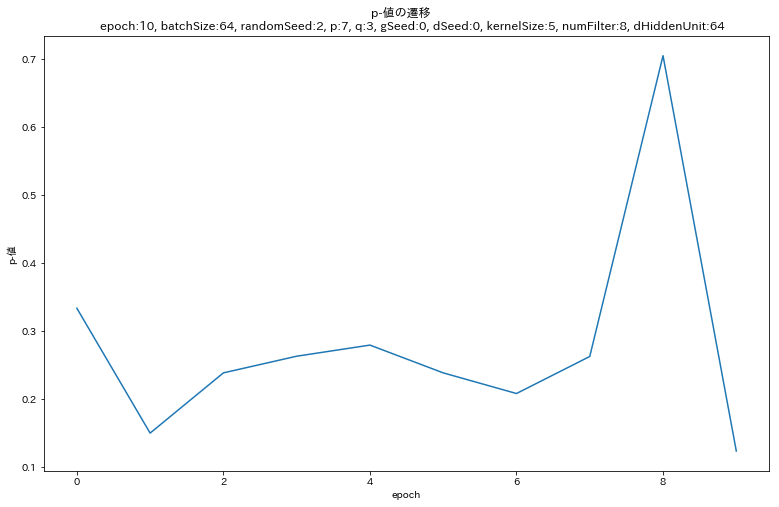

In [33]:
plt.figure(figsize=(13,8))
plt.plot(p_value)
plt.title("p-値の遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))
plt.xlabel("epoch")
plt.ylabel("p-値")
plt.savefig("output-images/p-value_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}.png"
            .format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))


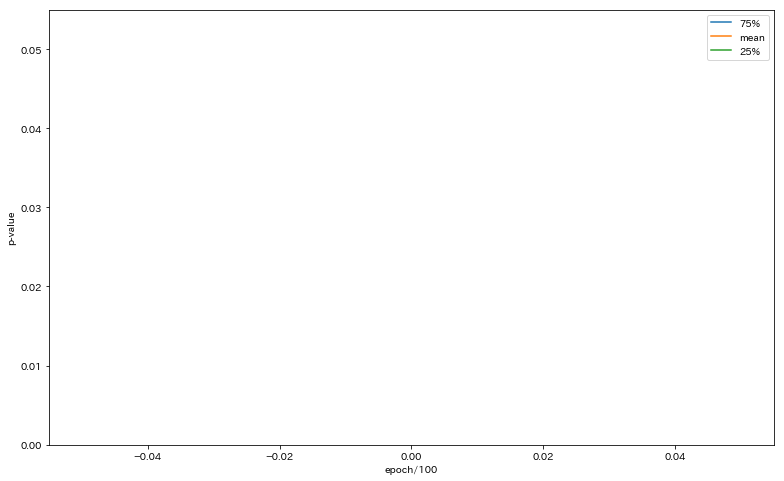

In [34]:
# 100iterごとの平均値をプロット
a=np.array(p_value)[:len(p_value)//100*100]
c_array = np.percentile(a.reshape([100,len(a)//100]), q=[0, 25, 50, 75, 100], axis=0)
plt.figure(figsize=(13,8))
plt.plot(c_array[3], label='75%')
# plt.plot(c_array[2], label='medium')
plt.plot(a.reshape([100,len(a)//100]).mean(axis=0), label='mean')
plt.plot(c_array[1], label='25%')
# plt.plot(c_array[0], label='min')
plt.xlabel("epoch/100")
plt.ylabel("p-value")
plt.ylim(0)
plt.legend()

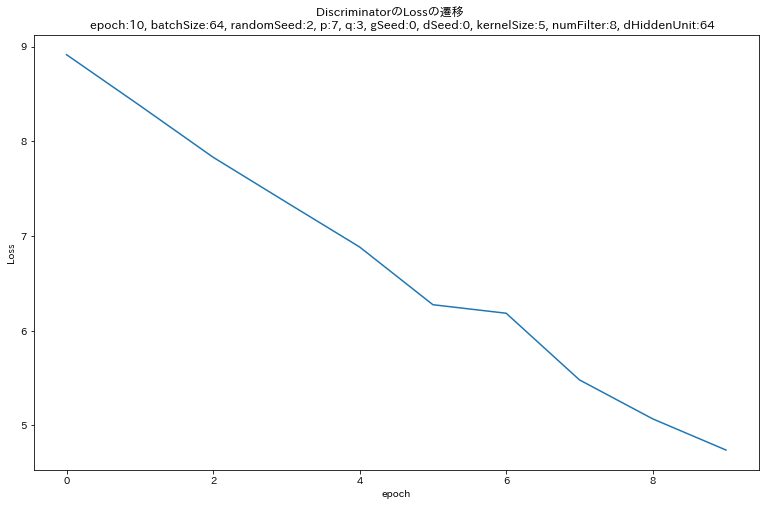

In [35]:
plt.figure(figsize=(13,8))
plt.title("DiscriminatorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_D_curve)
plt.savefig("output-images/loss-D-curve_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))


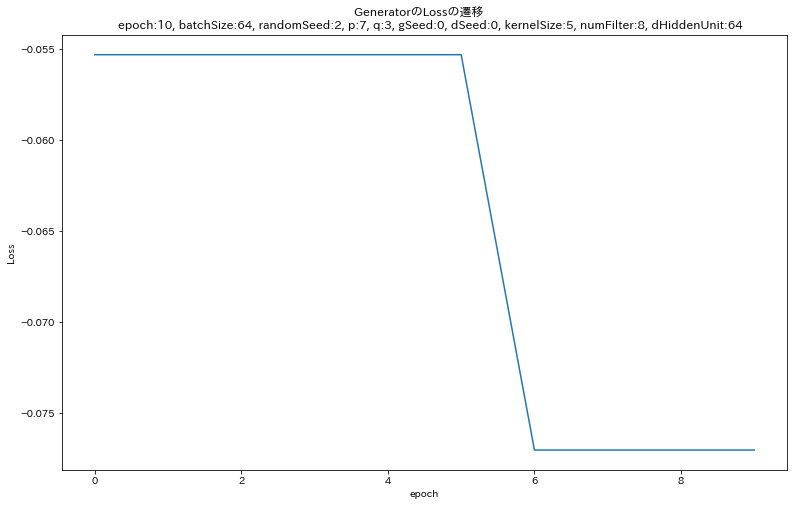

In [36]:
plt.figure(figsize=(13,8))
plt.title("GeneratorのLossの遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(loss_G_curve)
plt.savefig("output-images/loss-G-curve_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))


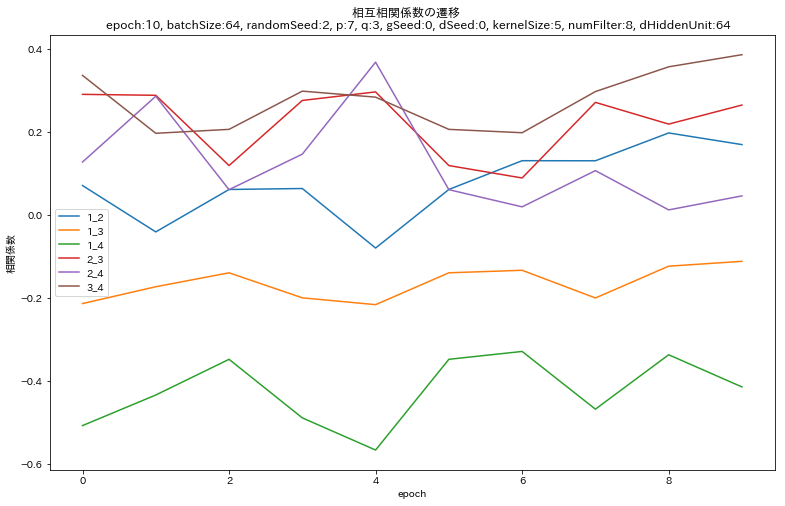

In [37]:
plt.figure(figsize=(13,8))
plt.title("相互相関係数の遷移　\n　epoch:{1}, batchSize:{2}, randomSeed:{3}, p:{4}, q:{5}, gSeed:{6}, dSeed:{7}, kernelSize:{8}, numFilter:{9}, dHiddenUnit:{10}".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))
plt.xlabel("epoch")
plt.ylabel("相関係数")
plt.plot(np.array(corrcoef)[:,1,0],label='1_2')
plt.plot(np.array(corrcoef)[:,2,0],label='1_3')
plt.plot(np.array(corrcoef)[:,3,0],label='1_4')
plt.plot(np.array(corrcoef)[:,2,1],label='2_3')
plt.plot(np.array(corrcoef)[:,3,1],label='2_4')
plt.plot(np.array(corrcoef)[:,3,2],label='3_4')
plt.legend()
plt.savefig("output-images/corrcoef_epoch{1}_batchSize{2}_randomSeed{3}_p{4}_q{5}_gSeed{6}_dSeed{7}_kernelSize{8}_numFilter{9}_dHiddenUnit{10}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.random_seed, opt.p, opt.q, opt.generator_seed, opt.discriminator_seed, opt.generator_kernel_size,opt.n_filter,opt.discriminator_hidden_unit))


## $F_{\phi}$の学習

In [39]:
X

tensor([[[-0.1974, -0.2190, -0.1234, -0.2254, -0.1825, -0.1664, -0.1881,
          -0.1365]],

        [[-0.2190, -0.1234, -0.2254, -0.1825, -0.1664, -0.1881, -0.1365,
          -0.2182]],

        [[-0.1234, -0.2254, -0.1825, -0.1664, -0.1881, -0.1365, -0.2182,
          -0.1636]],

        [[-0.2254, -0.1825, -0.1664, -0.1881, -0.1365, -0.2182, -0.1636,
          -0.2069]],

        [[-0.1825, -0.1664, -0.1881, -0.1365, -0.2182, -0.1636, -0.2069,
          -0.1831]],

        [[-0.1664, -0.1881, -0.1365, -0.2182, -0.1636, -0.2069, -0.1831,
          -0.1693]],

        [[-0.1881, -0.1365, -0.2182, -0.1636, -0.2069, -0.1831, -0.1693,
          -0.1952]],

        [[-0.1365, -0.2182, -0.1636, -0.2069, -0.1831, -0.1693, -0.1952,
          -0.2021]],

        [[-0.2182, -0.1636, -0.2069, -0.1831, -0.1693, -0.1952, -0.2021,
          -0.2734]],

        [[-0.1636, -0.2069, -0.1831, -0.1693, -0.1952, -0.2021, -0.2734,
          -0.1550]],

        [[-0.2069, -0.1831, -0.1693, -0.1952, -0.2

In [38]:
ああ

NameError: name 'ああ' is not defined

In [ ]:
loss_F=[]

for epoch in range(opt.n_epochs):# epochごとの処理

    for i, batch in enumerate(range(0, trainMatrix.shape[0]-opt.batch_size, opt.batch_size)):# batchごとの処理

        # generatorへの入力を用意する
        X = trainMatrix[batch:batch+opt.batch_size]# torch.Size([64, 1, 8])
#         時系列の順番はそのまま入力した方がいいのかな？
        rand=random.randint(0,trainMatrix.shape[0] - trainMatrix.shape[0]// opt.batch_size*opt.batch_size)
        X = trainMatrix[batch+rand : batch+rand+opt.batch_size]# torch.Size([64, 1, 8])
    
        X = Variable(X)# 自動微分？
        
        # ---------------------
        #  Train net(次時刻を予測するネットワークFφの学習)
        # ---------------------
        

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
a = val_hat_epsilon[:,0].cpu().detach().numpy()

In [ ]:
from scipy.stats import norm

In [ ]:
kde = gaussian_kde(a)
ls = np.linspace(min(a)-np.var(a), max(a)+np.var(a) , 100)
# kde(ls)
# ls=np.linspace(-0,3)
plt.plot(ls, kde.pdf(ls) , label="$\hat\epsilon$")
plt.plot(ls, norm.pdf(ls), label="$\mathcal{N}(0,1)$")
plt.legend()

In [ ]:
np.linspace(0.06,0.07,10)
(kde.pdf(np.linspace(0.055,0.075,200))*0.0001).sum()

In [ ]:
norm.pdf([0.07,0.071])

In [ ]:
ls=np.linspace(-0,3)

In [ ]:
plt.plot(ls, norm.pdf(ls))

In [ ]:
a = norm.rvs(size=opt.batch_size)
kde = gaussian_kde(a)
ls = np.linspace(min(a)-np.var(a), max(a)+np.var(a) , 100)
# kde(ls)
# ls=np.linspace(-0,3)
plt.plot(ls, kde.pdf(ls) , label="epsilon")
plt.plot(ls, norm.pdf(ls), label="norm")
plt.legend()